# Diffusion Models for Image Segmentation

https://www.kaggle.com/code/user164919/diffusion-models-for-image-segmentation

In [1]:
import logging
import os
import tempfile
import time
from glob import glob

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, load_decathlon_datalist, CacheDataset
from monai.utils import set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import logger

from generative.inferers import DiffusionInferer
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet
from generative.networks.schedulers.ddpm import DDPMScheduler

torch.multiprocessing.set_sharing_strategy('file_system')
print_config()

_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
LOG_PATH = f"training_log_{_time}.txt"
if not os.path.exists(LOG_PATH):
    with open(LOG_PATH, 'w') as f:
        pass

MONAI version: 1.3.1
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /home/<username>/anaconda3/envs/diffusion/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s', handlers=[
    logging.FileHandler(LOG_PATH),
    logging.StreamHandler()
])
logger = logging.getLogger(__name__)

In [3]:
root_dir = '../../../mnt/sda/suhohan/hutu-80'

In [4]:
set_determinism(2650)

### Dataset

In [5]:
dataset_descr_json = {
    "description": "Hutu-80 dataset",
    "name": "Hutu-80 Dataset",
    "test": [],
    "training": [],
    "validation": []
}

all_images = glob(os.path.join(root_dir, 'images', '*.png'))
logger.info(f'Found {len(all_images)} images')

train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=2650)
logger.info(f'Train images: {len(train_images)}, Test images: {len(test_images)}')

dataset_descr_json['training'] = []
for image in tqdm(train_images, desc='Processing training images'):
    dataset_descr_json['training'].append({
        'image': image,
        'label': image.replace('images', 'masks')
    })

dataset_descr_json["validation"] = []
for image in tqdm(test_images, desc='Processing validation images'):
    dataset_descr_json['validation'].append({
        'image': image,
        'label': image.replace('images', 'masks')
    })

logger.info(f"dataset_descr_json[training]: {len(dataset_descr_json['training'])}")
logger.info(f"dataset_descr_json[validation]: {len(dataset_descr_json['validation'])}")

[28/Jun/2024 00:28:45] INFO - Found 180 images
[28/Jun/2024 00:28:45] INFO - Train images: 144, Test images: 36


Processing validation images: 100%|██████████| 36/36 [00:00<00:00, 557176.92it/s]

[28/Jun/2024 00:28:45] INFO - dataset_descr_json[training]: 144
[28/Jun/2024 00:28:45] INFO - dataset_descr_json[validation]: 36


In [6]:
import json

split_JSON = "./dataset_0.json"
with open(split_JSON, 'w') as fp:
    json.dump(dataset_descr_json, fp)

In [7]:
train_transforms = transforms.Compose(
    [
        # 이미지와 레이블 데이터를 메모리에 로드
        transforms.LoadImaged(keys=["image", "label"]),
        # 채널을 첫 번째 차원으로 변환
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        # 레이블 데이터를 이진화
        transforms.Lambdad(keys=["label"], func=lambda x: np.where(
            x[0, :, :].unsqueeze(0) > 127, 1, 0), overwrite=True),
        # 데이터를 PyTorch 텐서 형식으로 변환
        transforms.EnsureTyped(keys=["image", "label"]),
        # 이미지 크기 조정
        transforms.Resized(keys=["image", "label"], spatial_size=(512, 512), mode=["bilinear", "nearest"]),
        # 이미지 강도를 0에서 1 사이로 스케일링
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
    ]
)

In [8]:
train_files = load_decathlon_datalist(split_JSON, True, 'training')
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)

Loading dataset: 100%|██████████| 144/144 [00:09<00:00, 15.50it/s]


In [9]:
logger.info(f"Length of training data: {len(train_ds)}")
logger.info(f'Train image shape {train_ds[0]["image"].shape}')
logger.info(f'Train label shape {train_ds[0]["label"].shape}')

[28/Jun/2024 00:28:54] INFO - Length of training data: 144
[28/Jun/2024 00:28:54] INFO - Train image shape torch.Size([3, 512, 512])
[28/Jun/2024 00:28:54] INFO - Train label shape torch.Size([1, 512, 512])


In [10]:
batch_size = 4
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True, persistent_workers=True
)

In [11]:
val_files = load_decathlon_datalist(split_JSON, True, 'validation')
val_ds = CacheDataset(data=val_files, transform=train_transforms, cache_rate=1.0, num_workers=4)

Loading dataset: 100%|██████████| 36/36 [00:02<00:00, 15.43it/s]


In [12]:
logger.info(f"Length of training data: {len(val_ds)}")
logger.info(f'Validation image shape {val_ds[0]["image"].shape}')
logger.info(f'Validation label shape {val_ds[0]["label"].shape}')

[28/Jun/2024 00:28:57] INFO - Length of training data: 36
[28/Jun/2024 00:28:57] INFO - Validation image shape torch.Size([3, 512, 512])
[28/Jun/2024 00:28:57] INFO - Validation label shape torch.Size([1, 512, 512])


In [13]:
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)

### Network

In [14]:
device = torch.device("cuda:3")

In [15]:
model = DiffusionModelUNet(spatial_dims=2, in_channels=4, out_channels=1, num_channels=(64, 64, 64), attention_levels=(
    False, False, True), num_res_blocks=1, num_head_channels=64, with_conditioning=False)
model.to(device)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
       

### Training

In [16]:
n_epochs = 10
n_timesteps = 10
val_interval = 5
epoch_loss_list = []
val_epoch_loss_list = []

In [17]:
scheduler = DDPMScheduler(num_train_timesteps=n_timesteps)
optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)
inferer = DiffusionInferer(scheduler)

In [18]:
scaler = GradScaler()
total_start = time.time()

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0

    for step, data in enumerate(train_loader):
        images = data["image"].to(device)
        seg = data["label"].to(device)
        optimizer.zero_grad()
        timesteps = torch.randint(0, n_timesteps, (len(images),)).to(device)

        with autocast(enabled=True):
            noise = torch.randn_like(seg).to(device)
            noisy_seg = scheduler.add_noise(original_samples=seg, noise=noise, timesteps=timesteps)
            combined = torch.cat((images, noisy_seg), dim=1)
            img_array = noisy_seg[0, 0].detach().cpu().numpy()
            if step == 0:
                plt.imsave(f'noisy_seg_epoch{epoch}_step{step}.png', img_array, cmap='gray')

            prediction = model(x=combined, timesteps=timesteps)
            loss = F.mse_loss(prediction.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    logger.info(f"Epoch: {epoch} Training loss: {epoch_loss / (step + 1)}")

    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, data_val in enumerate(val_loader):
            images = data_val["image"].to(device)
            seg = data_val["label"].to(device)
            timesteps = torch.randint(0, n_timesteps, (len(images),)).to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(seg).to(device)
                    noisy_seg = scheduler.add_noise(original_samples=seg, noise=noise, timesteps=timesteps)
                    combined = torch.cat((images, noisy_seg), dim=1)
                    prediction = model(x=combined, timesteps=timesteps)
                    val_loss = F.mse_loss(prediction.float(), noise.float())
            val_epoch_loss += val_loss.item()
        logger.info(f"Epoch: {epoch} Validation loss: {val_epoch_loss / (step + 1)}")
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

torch.save(model.state_dict(), "./segmodel.pt")
total_time = time.time() - total_start
minutes = total_time // 60
seconds = total_time % 60

logger.info(f"train diffusion completed, total time: {int(minutes)}m {int(seconds)}s.")

[28/Jun/2024 00:29:21] INFO - Epoch: 0 Training loss: 0.955830016069942
[28/Jun/2024 00:29:23] INFO - Epoch: 0 Validation loss: 0.8746131923463609
[28/Jun/2024 00:29:45] INFO - Epoch: 1 Training loss: 0.7785088585482703
[28/Jun/2024 00:30:07] INFO - Epoch: 2 Training loss: 0.6014079186651442
[28/Jun/2024 00:30:30] INFO - Epoch: 3 Training loss: 0.4631803904970487
[28/Jun/2024 00:30:52] INFO - Epoch: 4 Training loss: 0.3515453760822614
[28/Jun/2024 00:31:14] INFO - Epoch: 5 Training loss: 0.2665640434457196
[28/Jun/2024 00:31:16] INFO - Epoch: 5 Validation loss: 0.22174439827601114
[28/Jun/2024 00:31:38] INFO - Epoch: 6 Training loss: 0.19917823870976767
[28/Jun/2024 00:32:01] INFO - Epoch: 7 Training loss: 0.15079981543951565
[28/Jun/2024 00:32:23] INFO - Epoch: 8 Training loss: 0.11165159402622117
[28/Jun/2024 00:32:45] INFO - Epoch: 9 Training loss: 0.09093563962313864
[28/Jun/2024 00:32:45] INFO - train diffusion completed, total time: 3m 48s.


In [19]:
print(len(val_epoch_loss_list))

2


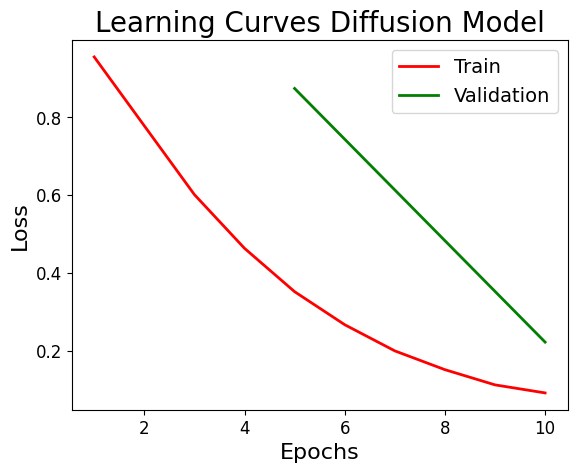

<Figure size 640x480 with 0 Axes>

In [21]:
plt.title("Learning Curves Diffusion Model", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="red", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    color="green",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()
plt.savefig("diffusion learning curve.png")

### Sampling

[28/Jun/2024 00:42:11] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.012148].


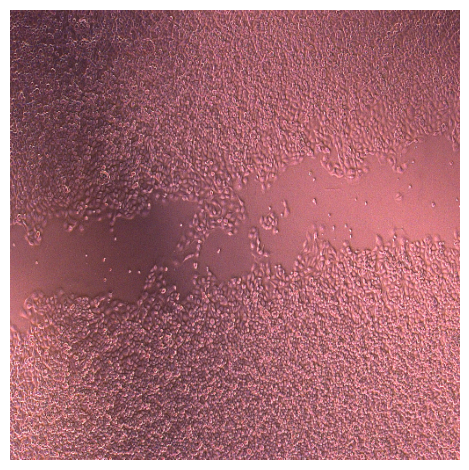

<Figure size 640x480 with 0 Axes>

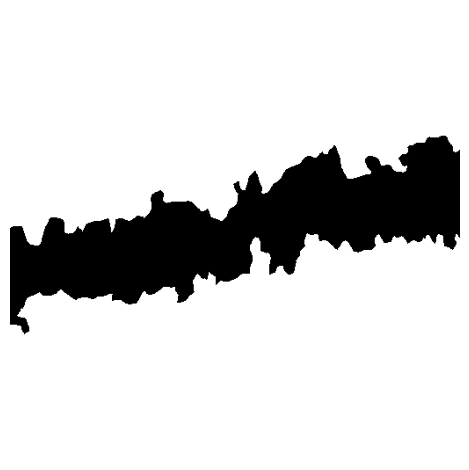

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
       

<Figure size 640x480 with 0 Axes>

In [22]:
idx = 0
data = val_ds[idx]
inputimg = data["image"]
inputlabel = data["label"]

plt.figure("input"+str(inputlabel))
plt.imshow(inputimg.T, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()
plt.savefig("input_image.png")

plt.figure("input"+str(inputlabel))
plt.imshow(inputlabel.T, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()
plt.savefig("input_label.png")

model.eval()

In [ ]:
n = 5
input_img = inputimg[None, ...].to(device)

ensemble = []
for k in range(5):
    noise_shape = list(input_img.shape)
    noise_shape[1] = 1
    noise = torch.randn(noise_shape).to(device)
    current_img = noise
    combined = torch.cat((input_img, noise), dim=1)
    scheduler.set_timesteps(num_inference_steps=n_timesteps)
    progress_bar = tqdm(scheduler.timesteps)
    chain = torch.zeros(current_img.shape)
    for t in progress_bar:
        with autocast(enabled=False):
            with torch.no_grad():
                model_output = model(combined, timesteps=torch.Tensor((t,)).to(current_img.device))
                current_img, _ = scheduler.step(model_output, t, current_img)
                if t % (n_timesteps//10) == 0:
                    chain = torch.cat((chain, current_img.cpu()), dim=-1)
                combined = torch.cat((input_img, current_img), dim=1)
    plt.style.use("default")
    plt.imshow(chain[0, 0, ..., 512:].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    plt.savefig(f"sampling_{k}.png")
    ensemble.append(current_img)

### Prediction

In [ ]:
def dice_coeff(im1, im2, empty_score=1.0):
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    intersection = np.logical_and(im1, im2)

    return 2.0 * intersection.sum() / im_sum

In [ ]:
for i in range(len(ensemble)):
    prediction = torch.where(ensemble[i] > 0.5, 1, 0).float()
    score = dice_coeff(prediction[0, 0].cpu(), inputlabel.cpu())
    logger.info(f"Dice score of sample{str(i)}: {score}")

E = torch.where(torch.cat(ensemble) > 0.5, 1, 0).float()
var = torch.var(E, dim=0)
mean = torch.mean(E, dim=0)
mean_prediction = torch.where(mean > 0.5, 1, 0).float()

score = dice_coeff(mean_prediction[0, ...].cpu(), inputlabel.cpu())
logger.info(f"Dice score on the mean map: {score}")

plt.style.use("default")
plt.imshow(mean[0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()
plt.savefig("mean.png")
plt.style.use("default")
plt.imshow(var[0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()
plt.savefig("variance.png")